In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

# Data Loading and Visualization

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.1307, 0.3081)
])

train_data = datasets.MNIST('./MNIST', train=True, download=True, transform=transform)
test_data = datasets.MNIST("./MNIST", train=False, download=True, transform=transform)

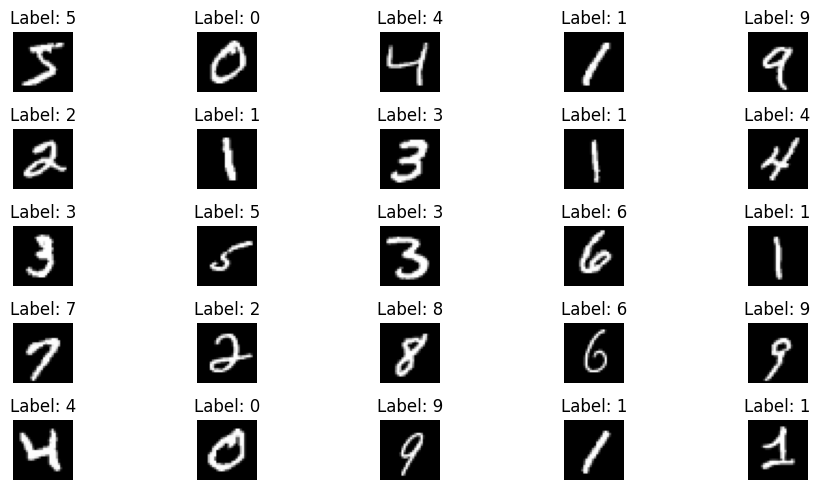

In [4]:
# Create a dictionary to store one image per label
# images_per_label = {}
images = []
# Loop through the dataset to find one image per label
for i, (img, label) in enumerate(train_data):
    if i == 25:  # Break the loop once we have all labels
        break
    # if label not in images_per_label:
    images.append((label, img))
    
# Plot the images, one per label
fig, axes = plt.subplots(5, 5, figsize=(10, 5))
for i, (label, img) in enumerate(images):
    ax = axes[i // 5, i % 5]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [5]:
batch_size = 1024
mnist_train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)
mnist_valid_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)

# Custom CNN Model

In [6]:
class MNIST_custom(nn.Module):
    def __init__(self):
        super().__init__()
        # 32x32x1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3) # 30x30x16
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2) # 15x15x16

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3) # 13x13x32
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2) # 5x5x32

        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(5 * 5 * 32, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))

        x = self.maxpool2(self.relu2(self.conv2(x)))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))

        x = self.dropout(x)

        x = self.fc2(x)

        return x


In [7]:
model = MNIST_custom()

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
model

MNIST_custom(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=800, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [49]:
num_epochs = 20

train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []

for epoch in range(num_epochs):
    
    ############################
    # Train
    ############################
    
    iter_loss = 0.0
    correct = 0
    iterations = 0
    
    model.train()                   # Put the network into training mode
    
    for i, (items, classes) in enumerate(mnist_train_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if torch.cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        optimizer.zero_grad()     # Clear off the gradients from any past operation
        outputs = model(items)      # Do the forward pass
        loss = criterion(outputs, classes) # Calculate the loss
        iter_loss += loss.item() # Accumulate the loss
        loss.backward()           # Calculate the gradients with help of back propagation
        optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        iterations += 1

    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append(100 * correct.cpu() / float(len(mnist_train_loader.dataset)))
   

    ############################
    # Validate - How did we do on the unseen dataset?
    ############################
    
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()
    
    for i, (items, classes) in enumerate(mnist_valid_loader):
        
        # Convert torch tensor to Variable
        items = Variable(items)
        classes = Variable(classes)
        
        # If we have GPU, shift the data to GPU
        if torch.cuda.is_available():
            items = items.cuda()
            classes = classes.cuda()
        
        outputs = model(items)      # Do the forward pass
        loss += criterion(outputs, classes).item() # Calculate the loss
        
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == classes.data).sum()
        
        iterations += 1

    # Record the validation loss
    valid_loss.append(loss/iterations)
    # Record the validation accuracy
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(mnist_valid_loader.dataset) * 100.0)

    print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
           %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
             valid_loss[-1], valid_accuracy[-1]))

Epoch 1/20, Tr Loss: 0.4033, Tr Acc: 87.1767, Val Loss: 0.0632, Val Acc: 97.8200
Epoch 2/20, Tr Loss: 0.0741, Tr Acc: 97.7117, Val Loss: 0.0441, Val Acc: 98.5300
Epoch 3/20, Tr Loss: 0.0559, Tr Acc: 98.3100, Val Loss: 0.0342, Val Acc: 98.7500
Epoch 4/20, Tr Loss: 0.0433, Tr Acc: 98.6883, Val Loss: 0.0311, Val Acc: 98.9800
Epoch 5/20, Tr Loss: 0.0367, Tr Acc: 98.8167, Val Loss: 0.0299, Val Acc: 99.0500
Epoch 6/20, Tr Loss: 0.0368, Tr Acc: 98.8450, Val Loss: 0.0280, Val Acc: 99.0400
Epoch 7/20, Tr Loss: 0.0336, Tr Acc: 98.9900, Val Loss: 0.0351, Val Acc: 98.9300
Epoch 8/20, Tr Loss: 0.0295, Tr Acc: 99.0417, Val Loss: 0.0256, Val Acc: 99.1600
Epoch 9/20, Tr Loss: 0.0311, Tr Acc: 99.0000, Val Loss: 0.0306, Val Acc: 99.0700
Epoch 10/20, Tr Loss: 0.0264, Tr Acc: 99.1483, Val Loss: 0.0296, Val Acc: 99.1100
Epoch 11/20, Tr Loss: 0.0230, Tr Acc: 99.2550, Val Loss: 0.0284, Val Acc: 99.0600
Epoch 12/20, Tr Loss: 0.0250, Tr Acc: 99.1750, Val Loss: 0.0299, Val Acc: 99.0800
Epoch 13/20, Tr Loss: 0.0

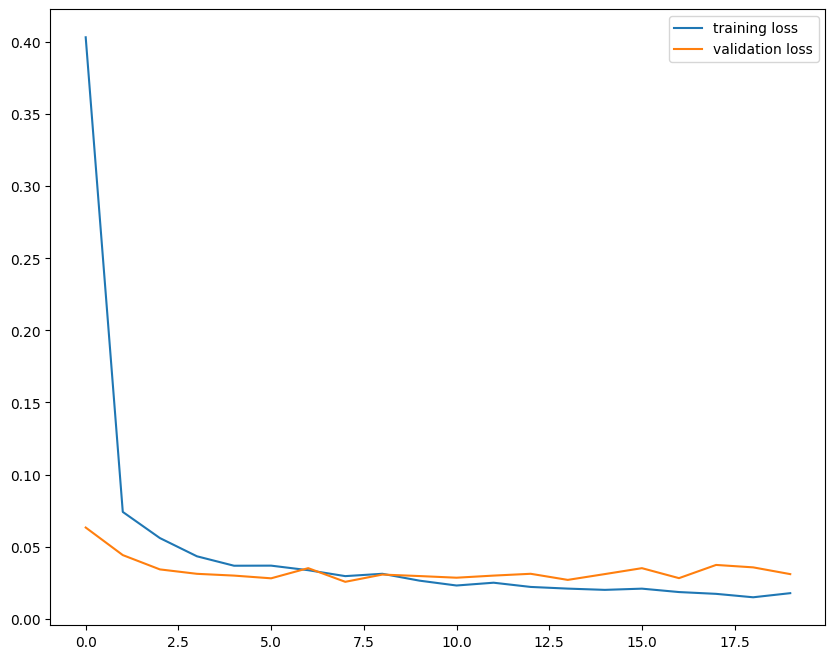

In [50]:
# Plot loss curves

f = plt.figure(figsize=(10, 8))
plt.plot(train_loss, label='training loss')
plt.plot(valid_loss, label='validation loss')
plt.legend()
plt.show()

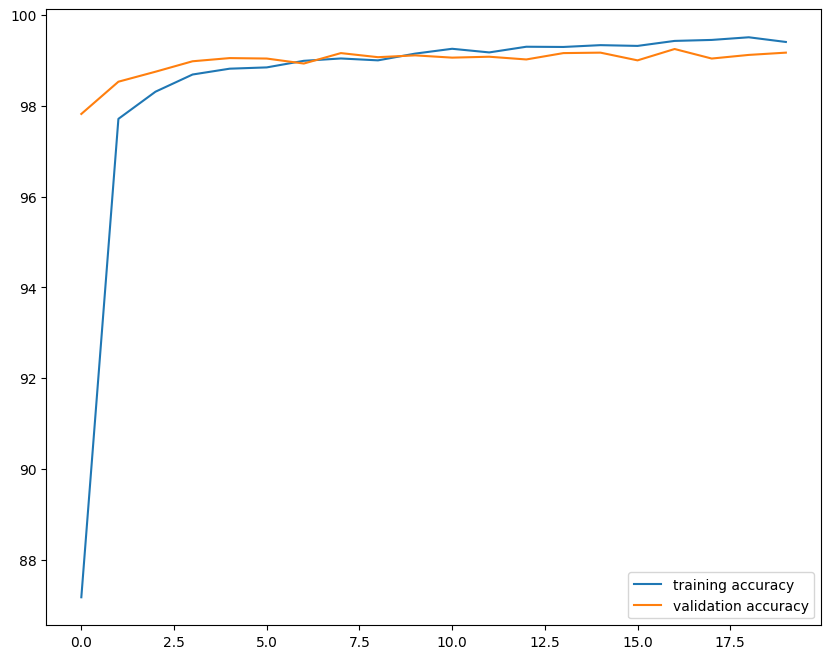

In [51]:
f = plt.figure(figsize=(10, 8))
plt.plot(train_accuracy, label='training accuracy')
plt.plot(valid_accuracy, label='validation accuracy')
plt.legend()
plt.show()

# Visualization

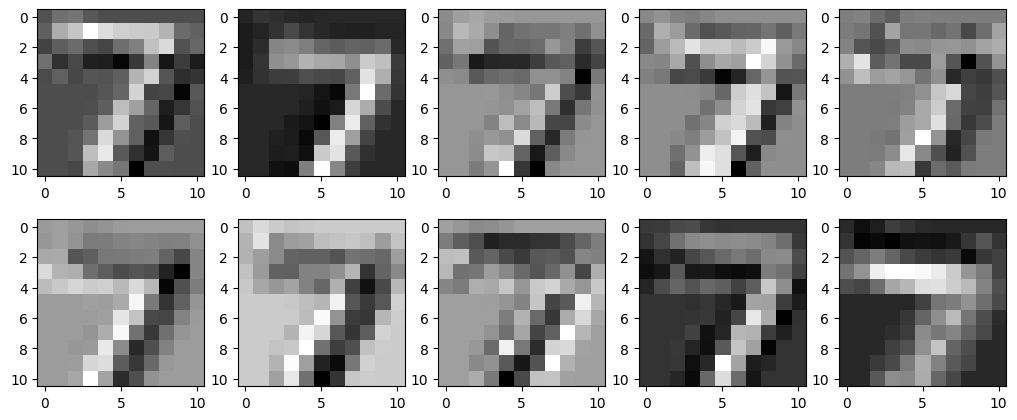

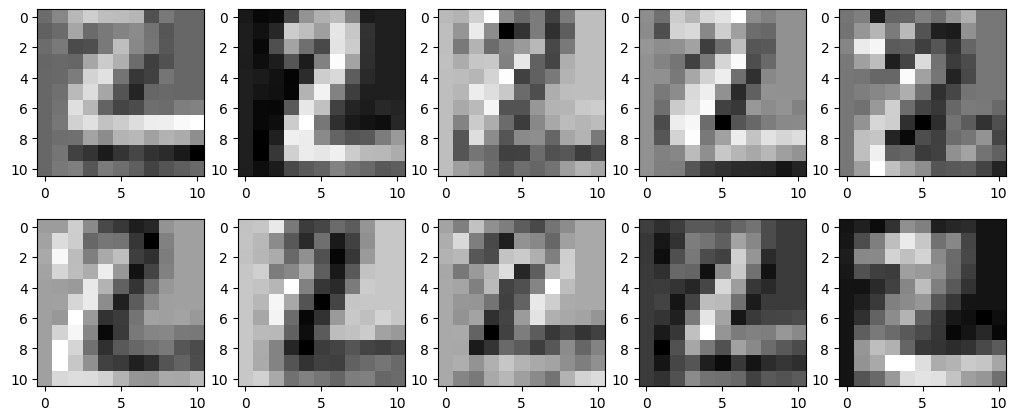

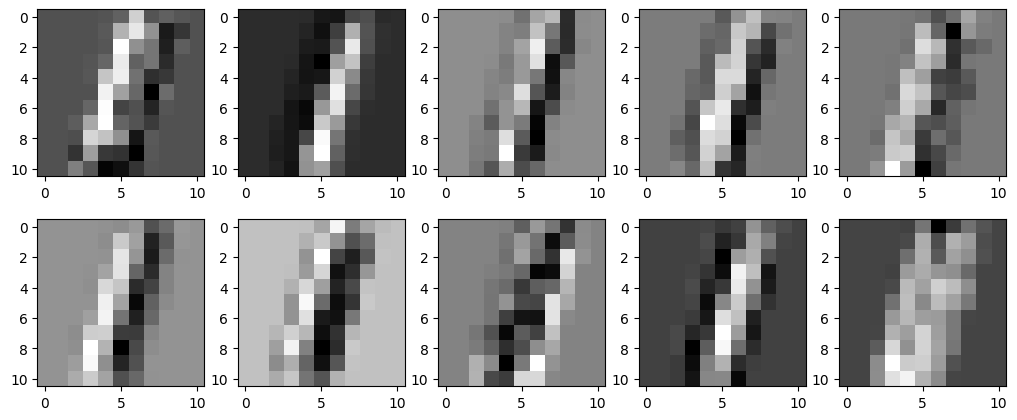

In [9]:
# Visualize feature maps
activation = {}         # initializes empty dictionary to store the feature maps

# returns a hook function,
def get_activation(name):
    # hook will capture the layer's output (output) and store it in the activation dictionary with the specified name.
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv2.register_forward_hook(get_activation('conv2')) # This line registers the hook on the first convolutional layer (conv1).
j = 0
for test_ in test_data:
  if j == 3:
     break
  j += 1
  data, _ = test_                                           # retrieves a single test sample from the dataset test_ds (data,label)
  data.unsqueeze_(0)     # Since this is a single image, unsqueeze_(0) changes its shape from [1, 28, 28] to [1, 1, 28, 28], where 1 is the batch size
  output = model(data.cuda())  # output is not required for this case since we stored activations

  fm_cov1 = activation['conv2'].squeeze().cpu().detach().numpy()  # .squeeze(): Removes the extra batch dimension added earlier, so the feature map has the shape [out_channels, height, width].
  fig = plt.figure(figsize=[5*2.5, 2*2.5])
  for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(fm_cov1[i], cmap='gray')
  
# The feature maps are the result of applying the learned filters to the input image, so they represent specific patterns or structures detected by the filters. 